## CNN Training
#### In this notebook we train a CNN for detecting mitosis using the hard GT mitosis and the negative samples previously extracted 
#### The adversarial lib uses gradient reversal layer from https://github.com/michetonu/gradient_reversal_keras_tf

In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [2]:
import keras
from keras.applications.densenet import DenseNet121
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations, Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from matplotlib.pyplot import imread
import random
from sklearn.metrics.pairwise import manhattan_distances

from os.path import join, basename, dirname, exists  
import os  
import glob
import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import Image

sys.path.insert(0, 'utils')
import utils_patches
import config
import importlib
importlib.reload(utils_patches)#Debugging purposes, not recomended in final version of the code!
from utils_patches import localize_mitosis, localize_mitosis_patches, extract_patches, load_image, plot_image
#import utils_patches import *
import configparser


/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#Definition of the CNN model
kernel_size = (4,4)
input_shape = (63,63,3)
nb_filters = 16 
pool_size = 2
def mitosis_model(lr,clip_norm):
    model_mitosis = Sequential() #Is sequential because all the 
    #Block 0
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),
                            padding='valid',
                            input_shape=input_shape))
    model_mitosis.add(Activation('relu'))
    #Block 1
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 2
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 3
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Flatten())
    #Block 4
    model_mitosis.add(Dense(128))#, activation= 'relu')
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('softmax'))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Dense(2,activation='softmax'))

    #Defining the optimizer
    sgd_opt = SGD(lr=lr, momentum=0.9, decay=0.9, nesterov=True)

    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1,decay=0.9)
    else:
        adam_opt = Adam(lr)

    model_mitosis.compile(loss='categorical_crossentropy',
              optimizer=adam_opt ,
              metrics=['mae','acc'])
    return model_mitosis

In [7]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    image = (image / 255) * (range_max - range_min) + range_min 

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()


Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/training/
(32, 63, 63, 3)
(32, 2)


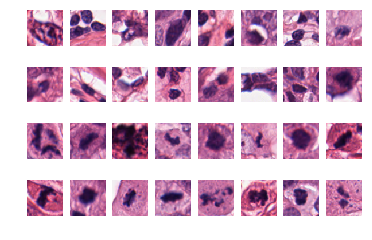

In [8]:
##Building the generators for balanced negative-positive batches

class simplePatchGenerator(object):
    def __init__(self, input_dir, batch_size, img_shape = (63,63,3), augmentation_fn=None):
        print("Building generator for patches in " + input_dir)
        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.batch_size = batch_size  # number of patches per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        self.img_shape = img_shape
        self.list_positive = glob.glob(input_dir + 'mitosis/*.png')
        self.list_negative = glob.glob(input_dir + 'non_mitosis/*.png')
        self.encoder = OneHotEncoder(sparse=False)
        

        self.n_samples = len(self.list_negative +self.list_positive)
        self.n_batches = self.n_samples // self.batch_size
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch
        paths_negatives = random.sample(self.list_negative,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        paths_positives = random.sample(self.list_positive,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        images = []
        labels = np.concatenate((np.zeros((self.batch_size//2,1)), np.ones((self.batch_size//2,1))),axis=0)
        label_idx = 0
        for pathimg in paths_negatives+paths_positives:
            try:
                # Read image path
                # Read data and label
                image = load_image(pathimg)
                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                if image.shape != self.img_shape:
                    images.append(images[-1])
                    labels[label_idx] = labels[label_idx-1]
                else:
                    images.append(image)
                label_idx+=1
            except Exception as e:
                print('Failed reading img {idx}...'.format(idx=pathimg))
                print(e)
            label_idx += 1
            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, self.encoder.fit_transform(batch_y)#batch_y

# Test the data generator
training_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/training/', 
    batch_size=32,
    img_shape = (63,63,3)
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8) 
    break

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/
(32, 63, 63, 3)
(32, 2)


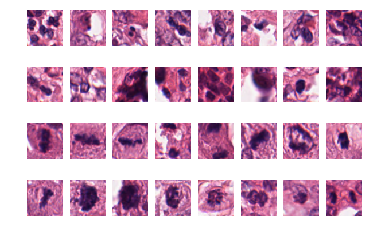

In [9]:
val_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/', 
    batch_size=32,
    img_shape = (63,63,3)
)
for batch_x, batch_y in val_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break
#batch_y

In [10]:
#Defining the CallBacks for tensorboard visualization and for earlystopping of the model
exp_name = 'baseline_lafrange'
checkpointer = ModelCheckpoint(filepath='/home/sebastian/local_experiments/staining/models/lafrange_model/'+exp_name+'decay_skL_softmax_ADAM_weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='/home/sebastian/local_experiments/staining/logs'+exp_name+'/', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [15]:
batch_size = 64
lambda_m = 0.1
epoch_size = 4000
Tp_min, Fp_max = 400, 100
model_mitosis = mitosis_model(lambda_m,True)


In [16]:
max_epochs = 10
trainPhase = False
if trainPhase:    
    model_mitosis.fit_generator(training_gen, epochs=max_epochs,verbose=1,callbacks=[checkpointer,tb_callback], validation_data=val_gen, validation_steps=20,steps_per_epoch=2000)

In [17]:
#Loading best model to check performance on test dataset
path_model_weights ='/home/sebastian/local_experiments/staining/models/lafrange_model/baseline_lafrangedecay_skL_softmax_ADAM_weights.10-0.50.hdf5'
model_mitosis.load_weights(path_model_weights)

In [18]:
#The path should be changed according to the ppartition being processed, i.e., training/val/test
path_test_images = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/test/mitosis/'
list_test_imgs = glob.glob(path_test_images + '**.png')
test_batches_paths = [list_test_imgs[i:i+64] for i in range(0,len(list_test_imgs),64)]

path_neg_test_images = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/test/non_mitosis/'
list_neg_test_imgs = glob.glob(path_neg_test_images + '**.png')
test_neg_batches_paths = [list_neg_test_imgs[i:i+64] for i in range(0,len(list_neg_test_imgs),64)]
print(len(list_test_imgs),len(list_neg_test_imgs))

533 12317


In [19]:
def evaluate_threshold_validation(model,validation_images_path,perf_meassure='f1'):
    list_val_imgs = glob.glob(validation_images_path + 'mitosis/' +  '**.png')
    val_batches_paths = [list_val_imgs[i:i+64] for i in range(0,len(list_val_imgs),64)]
    list_neg_test_imgs = glob.glob(validation_images_path + 'non_mitosis/' +'**.png')
    val_neg_batches_paths  = [list_neg_test_imgs[i:i+64] for i in range(0,len(list_neg_test_imgs),64)]
    
    #Computing probabilities for mitotic patches
    probabilites = []
    for batch in val_batches_paths:
        images_batch = []
        for pathimg in batch:
            image = load_image(pathimg)
            images_batch.append(image)    
        probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
        #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
    concat_probs = np.array([j for i in probabilites for j in i])
    
    #Computing probabilities for non mitotic patches
    neg_probabilites = []
    for batch in val_neg_batches_paths:
        images_batch = []
        for pathimg in batch:
            image = load_image(pathimg)
            images_batch.append(image)    
        neg_probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
        #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
    concat_neg_probs = np.array([j for i in neg_probabilites for j in i])
    gt_labels = np.concatenate((np.ones((len(concat_probs),1)),np.zeros((len(concat_neg_probs),1))),axis=0)
    all_probs = np.concatenate((concat_probs,concat_neg_probs),axis=0)
    fpr, tpr, thresholds = roc_curve(gt_labels, all_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True)
    roc_auc = auc(fpr,tpr)
    max_f1 = 0
    best_thres = 0
    for cur_thres in thresholds:
        cur_f1 = f1_score(gt_labels, all_probs[:,1]>cur_thres, average='macro')
        if cur_f1>max_f1:
            print(max_f1)
            max_f1 = cur_f1
            best_thres = cur_thres
    print("Best threshold found in validation is: " + str(best_thres) +  "; With f1="+str(max_f1))
    print(gt_labels.shape,all_probs.shape)
    best_threshold = 0
    return best_thres,max_f1,roc_auc

In [20]:
best_val_thres,max_f1,roc_auc = evaluate_threshold_validation(model_mitosis,'/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/',perf_meassure='f1')

0
0.4814814814814815
0.5438717860025366
0.5526332794830371
0.5610506126460285
0.6436606915086645
0.6512320606552937
0.7119402199652687
0.7142590740877685
0.7184592429267922
0.7185513928086693
0.7224938170452304
0.7320207820617992
0.737641811048494
0.7624930850082979
0.7634355937486085
0.7643312623745476
0.7672199158931698
0.7720891824938068
0.772775506012644
0.7823573511037067
0.7827402985634095
0.7831649831649832
0.785130998356786
Best threshold found in validation is: 0.8348074; With f1=0.7887731229202086
(1288, 1) (1288, 2)


/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
total_fp  = 0 
probabilites = []
for batch in test_batches_paths:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
concat_probs = np.array([j for i in probabilites for j in i])
print(len(concat_probs))


533


In [23]:
total_fp  = 0 
neg_probabilites = []
for batch in test_neg_batches_paths:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    neg_probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
concat_neg_probs = np.array([j for i in neg_probabilites for j in i])
print(len(concat_neg_probs))

12317


In [24]:
gt_labels = np.concatenate((np.ones((len(concat_probs),1)),np.zeros((len(concat_neg_probs),1))),axis=0)
all_probs = np.concatenate((concat_probs,concat_neg_probs),axis=0)
print(gt_labels.shape,all_probs.shape)

(12850, 1) (12850, 2)


In [25]:
fpr, tpr, thresholds = roc_curve(gt_labels, all_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True)
roc_auc = auc(fpr,tpr)

In [26]:
f1_test = f1_score(gt_labels, all_probs[:,1]>best_val_thres, average='macro')
print("F1 score in TEST : " + str(f1_test)) 

F1 score in TEST : 0.6425052748093628


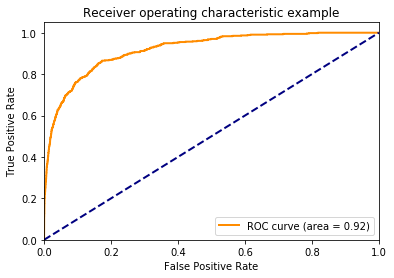

In [27]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


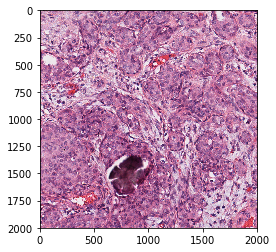

In [28]:
cases_test = [13,14,15,16,17,18,19,20,21,22,23] 
#Loading one image and doing dense prediction using a sliding window:
#ex_img = np.array(Image.open('/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/01.tif'))
ex_img = load_image('/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/06.tif', range_min=0, range_max=1)
plt.imshow(ex_img)

In [ ]:
# Sliding window CNN approach using list-comprehensions to speed up a little bit
probs_row = []
for i in range(ex_img.shape[1]-63): #This is a nice use case of list comprehension, for GPU mem limists is not possible to use only one line ranging also in the rows dim
    cur_batch_row = np.squeeze(np.array([[ex_img[i:i+63,j:j+63,:]/255. for j in range(ex_img.shape[1]-63)]]))
                                                      # \              /      |     \       /
                                                      #   <expression>    <targets>  <iterable>
    probs_row.append(model_mitosis.predict_proba(cur_batch_row))
    if i%100== 0:
        print("Computing probs for row " + str(i))
all_probs = np.array(probs_row)
all_probs.shape

Computing probs for row 0


In [272]:
from sklearn.metrics.pairwise import manhattan_distances
radius = 32
smf = np.zeros(mf.shape)
manhattan_distances([[p_m[0], p_m[1]]], [[p_m[0], p_m[1]]])[0][0] < 2*radius

True

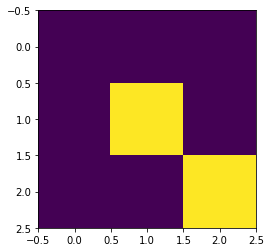

In [322]:
radius = 32
smf = np.zeros(mf.shape)
mf = all_probs[:,:,0]
bin_mask_mf = np.array(mf> threshold,dtype=int)
all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
plt.imshow(np.multiply(mf,bin_mask_mf)[27:30,1372:1375])

In [4]:

list_csv = glob.glob(config.PATH_GT + '**/*.csv')
print(len(list_csv))
dict_image_csv = d={i:[] for i in list(1+np.arange(73))}
for item in list_csv:
    casenum = int(item.split('/')[-2])
    if casenum in dict_image_csv.keys():
        dict_image_csv[casenum].append(item)
    else:
        dict_image_csv[casenum] = []
print(dict_image_csv.keys())

587
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])


In [5]:
dict_image_csv[13] 

['/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/13/06.csv',
 '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/13/09.csv']

In [353]:
for idx_case in cases_test:
    for csv_num in range(len(dict_image_csv[idx_case])):
        csv_path = dict_image_csv[idx_case][csv_num]
        coords_patches, patches = localize_mitosis_patches(csv_path)
        print(coords_patches)

NameError: name 'PREFIX_IMGS' is not defined

In [328]:
radius = 32
D = []
smf = np.zeros(mf.shape)
mf = all_probs[:,:,0]
bin_mask_mf = np.array(mf> threshold,dtype=int)
all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
while(len(all_pairs_p)>0):
    #plt.imshow(bin_mask_mf)
    p_m = np.unravel_index(np.argmax(np.multiply(mf,bin_mask_mf)), mf.shape) 
    p_m_val = np.max(np.multiply(mf,bin_mask_mf))
    print(p_m,p_m_val,len(all_pairs_p))
    D.append((p_m,p_m_val))
    for item in all_pairs_p:
        if manhattan_distances([[item[0], item[1]]], [[p_m[0], p_m[1]]])[0][0] < 2*radius:
            bin_mask_mf[item[0],item[1]] = 0
    all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))


(975, 796) 0.897356390953064 7264
(1871, 4) 0.8961186408996582 6868
(1461, 1721) 0.8954841494560242 6581
(1110, 363) 0.8954421877861023 6174
(1393, 1513) 0.893429696559906 5856
(874, 992) 0.8923826217651367 5210
(1376, 1099) 0.892102837562561 4949
(799, 733) 0.8904501795768738 4676
(1207, 1526) 0.8891072869300842 4377
(555, 1512) 0.8883779048919678 4218
(1468, 1581) 0.8877900838851929 3950
(1074, 414) 0.8868401646614075 3683
(436, 1378) 0.8863509297370911 3588
(1669, 679) 0.8862144351005554 3441
(1524, 670) 0.8859145641326904 3087
(878, 1552) 0.8859112858772278 2508
(1213, 1125) 0.8854284882545471 2432
(640, 1612) 0.8852502107620239 2162
(66, 1229) 0.8847835659980774 2016
(148, 813) 0.8843943476676941 1864
(1599, 724) 0.883345901966095 1735
(1172, 918) 0.8827938437461853 1595
(172, 1102) 0.8827530741691589 1382
(436, 319) 0.8826798796653748 1122
(756, 605) 0.882563054561615 994
(1268, 1168) 0.8820394277572632 935
(681, 1278) 0.8820195198059082 896
(1662, 1170) 0.881921112537384 832
(82

array([[0.16288307, 0.16317965, 0.16336158, ..., 0.16762681, 0.17159799,
        0.17464595],
       [0.16293874, 0.16308367, 0.16331072, ..., 0.16651404, 0.1685767 ,
        0.17049289],
       [0.16285071, 0.16299707, 0.1631401 , ..., 0.16523136, 0.16700874,
        0.16827306],
       ...,
       [0.13626774, 0.13736674, 0.13917626, ..., 0.77254051, 0.77266902,
        0.77172464],
       [0.13778062, 0.13937666, 0.1404468 , ..., 0.7489686 , 0.74976838,
        0.75178218],
       [0.14016855, 0.14021637, 0.14177297, ..., 0.72916275, 0.73841149,
        0.74246091]])

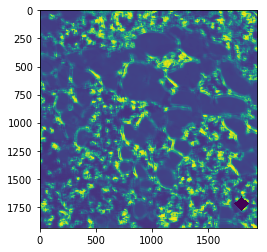

In [290]:
plt.imshow(smf)
smf

7264

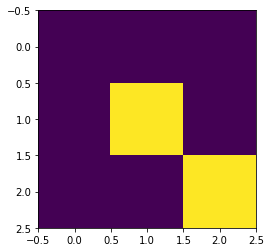

In [312]:
threshold = 0.87265426
plt.imshow(mf>threshold)
bin_mask_mf = np.array(mf> threshold,dtype=int)
plt.imshow(bin_mask_mf[27:30,1372:1375])
all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
len(all_pairs_p)

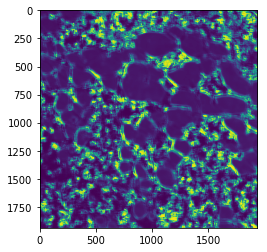

In [177]:
plt.imshow(all_probs[:,:,0])

In [215]:
mf = all_probs[:,:,0]
p_m = np.unravel_index(np.argmax(mf), mf.shape) 
p_m_val = np.max(mf)
p_m,p_m_val

smoothed_mf = 

((1720, 1790), 0.8932842)

In [182]:
kk = Image.fromarray(all_probs[:,:,0])

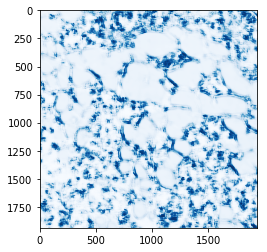

In [206]:
#mycmap = transparent_cmap(plt.cm.hot)
import scipy.misc


fig, ax = plt.subplots(1, 1)
ax.imshow(np.multiply(kk,255),cmap=plt.cm.Blues)
img_fname = 'Mf_img_' + str(1) + '.png'
out_file_path = '/home/sebastian/local_experiments/staining/results/tupac/images/'+img_fname
#scipy.misc.imsave(out_file_path, np.multiply(kk,255),cmap=plt.cm.Blues)
#fig.savefig('/home/sebastian/pp.png')

plt.imsave(
            out_file_path,
            np.multiply(kk,255),
            cmap=plt.cm.Blues,
            vmin=0,
            vmax=255)

In [ ]:
def nonmaximasupression(Mf,threshold,radius):
    
    return D,smoothed_Mf